# AlphaFold2 for protein structure prediction

## Computer lab notebook for [DDLS 2023 course](https://ddls.aicell.io/course/ddls-2023), module 6.

In this lab, we will analyze the alphafold neural network in order to understand how the network reasons about protein structure inference from protein sequence data. To make competent inferences fast, be sure to use the GPU environment. One inference step should take around 1 minute. For more information about the network and the wrapper we are using to speed up the calculations, you are welcome to review the following references:

This notebook modifies deepmind's [original notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) (**before AlphaFold-Multimer existed**) to add experimental support for modeling complexes (both homo and hetero-oligomers), option to run MMseqs2 instead of Jackhmmer for MSA generation and advanced functionality.

See [this github repo](https://github.com/oeway/ColabFold)(forked from [ColabFold](https://github.com/sokrypton/ColabFold)) for other related notebooks.

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

DO remember that this is an advanced lab and you are expected to, among other things, find information on your own, devise strategies for analysis, write your own code in the framework of this notebook, and provide discussion and answers to the questions to the 2 tasks. Good luck!



In [2]:
#@title Install software
#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left. We first need to install the required software to be able to analyze the results.

# setup device
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook

install_jackhmmer = True
GIT_REPO = 'https://github.com/deepmind/alphafold'
COLAB_REPO = 'https://github.com/oeway/ColabFold.git'
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
    #if not os.path.isdir("alphafold"):
    # download alphafold code
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")
    os.system(f"git clone {COLAB_REPO} ColabFold")
    # apply patches
    sys.path.append(f'ColabFold/beta/')
    if 'ColabFold/beta' not in sys.path:
        sys.path.append('ColabFold/beta')
    for name in ["model","modules","folding","config"]:
       with open(f'ColabFold/beta/{name}.patch','r') as file:
           f=file.readlines()
       w = open(f'alphafold/alphafold/model/{name}.py','w')
       for line in f:
           w.write(line)
       w.close()
    with open(f'ColabFold/beta/protein.patch','r') as file:
         f=file.readlines()
    w = open(f'alphafold/alphafold/common/protein.py','w')
    for line in f:
        w.write(line)
    w.close()
    pbar.update(4)
    os.system(f"pip install biopython dm-haiku==0.0.5 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  #else:
  #  pbar.update(55)

########################################################################################
# --- Python imports ---
if 'alphafold' not in sys.path:
  sys.path.append('alphafold')
if 'ColabFold/beta' not in sys.path:
  sys.path.append('ColabFold/beta')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

Running on GPU


  0%|          | 0/55 [elapsed: 00:00 remaining: ?]

/usr/local/lib/python3.10/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [3]:
#@title Enter the amino acid sequence to fold ⬇️
import re

# define sequence
sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
jobname = "test" #@param {type:"string"}
homooligomer =  "1" #@param {type:"string"}

#@markdown - `sequence` Specify protein sequence to be modelled.
#@markdown  - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
#@markdown  - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
#@markdown  - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`.
#@markdown    If `pair_msa` is enabled, `ACDE`'s MSA will be paired with `FGH`'s MSA.
#@markdown - `homooligomer` Define number of copies in a homo-oligomeric assembly.
#@markdown  - Use `:` to specify different homooligomeric state (copy numer) for each component of the complex.
#@markdown  - For example, **sequence:**`ABC:DEF`, **homooligomer:** `2:1`, the first protein `ABC` will be modeled as a homodimer (2 copies) and second `DEF` a monomer (1 copy).

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)

homooligomer: 1
total_length: 59
output_dir: prediction_test_a5e17


running mmseqs2


  0%|          | 0/150 [elapsed: 00:00 remaining: ?]

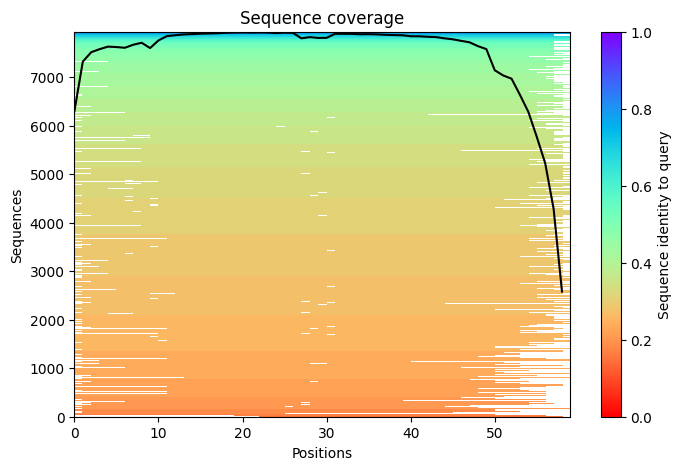

In [4]:
#@title Search against genetic databases
#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment
#@markdown (MSA) that will be used by AlphaFold. In particular,
#@markdown you’ll see how well each residue is covered by similar
#@markdown sequences in the MSA.
#@markdown (Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.)

#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","jackhmmer","single_sequence","precomputed"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `jackhmmer` - default method from Deepmind (SLOW, but may find more/less sequences).
#@markdown - `single_sequence` - use single sequence input
#@markdown - `precomputed` If you have previously run this notebook and saved the results,
#@markdown you can skip this step by uploading
#@markdown the previously generated  `prediction_?????/msa.pickle`


#@markdown ---
#@markdown **custom msa options**
add_custom_msa = False #@param {type:"boolean"}
msa_format = "fas" #@param ["fas","a2m","a3m","sto","psi","clu"]
#@markdown - `add_custom_msa` - If enabled, you'll get an option to upload your custom MSA in the specified `msa_format`. Note: Your MSA will be supplemented with those from 'mmseqs2' or 'jackhmmer', unless `msa_method` is set to 'single_sequence'.

#@markdown ---
#@markdown **pair msa options**

#@markdown Experimental option for protein complexes. Pairing currently only supported for proteins in same operon (prokaryotic genomes).
pair_mode = "unpaired" #@param ["unpaired","unpaired+paired","paired"] {type:"string"}
#@markdown - `unpaired` - generate seperate MSA for each protein.
#@markdown - `unpaired+paired` - attempt to pair sequences from the same operon within the genome.
#@markdown - `paired` - only use sequences that were sucessfully paired.

#@markdown Options to prefilter each MSA before pairing. (It might help if there are any paralogs in the complex.)
pair_cov = 50 #@param [0,25,50,75,90] {type:"raw"}
pair_qid = 20 #@param [0,15,20,30,40,50] {type:"raw"}
#@markdown - `pair_cov` prefilter each MSA to minimum coverage with query (%) before pairing.
#@markdown - `pair_qid` prefilter each MSA to minimum sequence identity with query (%) before pairing.

# --- Search against genetic databases ---

I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I

if len(I["msas"][0]) > 1:
  plt = cf.plot_msas(I["msas"], I["ori_sequence"])
  plt.savefig(os.path.join(I["output_dir"],"msa_coverage.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

In [5]:
#@title Filter options (optional)
trim = "" #@param {type:"string"}
trim_inverse = False #@param {type:"boolean"}
#@markdown - Use `trim` to specify regions to trim. For example: `trim:5-9,20` will remove positions 5,6,7,8,9 and 20.
#@markdown  - For complexes, you can use `trim:A1-A3,B5-B7` to remove positions 1,2,3 in 1st protein and positions 5,6,7 in 2nd protein.
#@markdown  - Note: This function is 1-indexed, meaning the first position is 1, not 0.
#@markdown  - To specify regions to keep instead of trim, enable `trim_inverse`
cov = 0 #@param [0,25,50,75,90,95] {type:"raw"}
qid = 0 #@param [0,15,20,25,30,40,50] {type:"raw"}
#@markdown - `cov` minimum coverage with query (%)
#@markdown - `qid` minimum sequence identity with query (%)

mod_I = cf_af.prep_filter(I, trim, trim_inverse, cov, qid)

if I["msas"] != mod_I["msas"]:
  plt.figure(figsize=(16,5),dpi=100)
  plt.subplot(1,2,1)
  plt.title("Sequence coverage (Before)")
  cf.plot_msas(I["msas"], I["ori_sequence"], return_plt=False)
  plt.subplot(1,2,2)
  plt.title("Sequence coverage (After)")
  cf.plot_msas(mod_I["msas"], mod_I["ori_sequence"], return_plt=False)
  plt.savefig(os.path.join(I["output_dir"],"msa_coverage.filtered.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

In [6]:
#@title Run alphafold
num_relax = "None"
rank_by = "pLDDT"
use_turbo = True
max_msa = "512:1024"
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]

#@markdown Before we run our alphafold prediction, we need to define a few options and variables. Have a look in the code to see the scope of parameters that need to be set. For instance, the parameter `use_turbo` introduces a few modifications (compile once, swap params, adjust max_msa) to speedup and reduce memory requirements. Disable for default behavior. Here is how you would implement the feature (see corresponding code block)
show_images = True #@param {type:"boolean"}
#@markdown - `show_images` To make things more exciting we show images of the predicted structures as they are being generated. (WARNING: the order of images displayed does not reflect any ranking).

#@markdown ---
#@markdown **Sampling options**

#@markdown There are two stochastic parts of the pipeline. Within the feature generation (choice of cluster centers) and within the model (dropout).
#@markdown To get structure diversity, you can iterate through a fixed number of random_seeds (using `num_samples`) and/or enable dropout (using `is_training`).
#@markdown To speed up the claculation on a GPU we only use the bare necessary options, such as only one sample and one model etc. If you were concerned with model quality, you would have to change
#@markdown these parameters. When evaluating model quality and robustness though, this is less important.
num_models = 1 #@param [1,2,3,4,5] {type:"raw"}
use_ptm = True
num_ensemble = 1
max_recycles = 1
is_training = False
num_samples = 1
#@markdown - `num_models` specify how many model params to try. (5 recommended, but we use 1 to speed up calculations)
subsample_msa = True

if not use_ptm and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

# prep input features
feature_dict = cf_af.prep_feats(mod_I, clean=IN_COLAB)
Ls_plot = feature_dict["Ls"]

# prep model options
opt = {"N":len(feature_dict["msa"]),
       "L":len(feature_dict["residue_index"]),
       "use_ptm":use_ptm,
       "use_turbo":use_turbo,
       "max_recycles":max_recycles,
       "tol":0.0,
       "num_ensemble":num_ensemble,
       "max_msa_clusters":max_msa_clusters,
       "max_extra_msa":max_extra_msa,
       "is_training":is_training}

#@markdown ---
#@markdown **Task 1 - Evoformer Inference**

#@markdown Begin with running one prediction of alphafold so that you see what the predicted structure for the given input sequence is.
#@markdown Make sure to time how long the prediction (inference) of our sequence of interest takes so that you can make informed choices
#@markdown about how many different parameters you can perturb in task 2. In this task, you will analyse how alphafold reasons about your sequence
#@markdown across the evoformer blocks (see Figure 1.).

#@markdown \


#@markdown |![](https://drive.google.com/uc?export=view&id=1V_kLp5rMBs6gnEXm4cFPp6X-8ISZv4TX)|
#@markdown |:--:|
#@markdown | <b>Figure 1. Overview of the entire alphafold network</b>|

#@markdown \

#@markdown After having run the inference, the `outs` variable is a dictionary of all the model outputs. For each model N (you only have one)
#@markdown and seed M (you still only have one), there is a key of the `outs` dictionary called *model_{N}_ptm_seed_{M-1}*. To access the results of the run,
#@markdown you can find the pair representations in `outs["model_1_ptm_seed_0"]["representations"]["all"]`. You will notice that the shape is `(48,r,r,c)`, where r,r,c is a single iteration of the pair representation

#@markdown To evaluate the behaviour of the inference, you will have to create a plot that shows how and when alphafold converges on the final pair representation.
#@markdown What are the characteristics of this function and how do you reason about its shape. What does this tell you about how alphafold makes the prediction?
#@markdown ***Hint***: *Try to find a suitable metric to measure the difference between each tensor of shape `r,r,c` and plots its evolution across blocks*.

#@markdown ---
#@markdown **Task 2 - Model Robustness**


#@markdown For a relatively complex generative model such as alphafold, many different layers are all providing their own input on the final inference. But surely,
#@markdown not all layers in the network are equally important. To understand which features are determined in each layer, and how robust the model is, a rudimentary option is
#@markdown to perturb the parameters of the model. In this implementation, this is determined by the `user_perturbation` parameter, which is divided into scopes and parameter spaces, which correspond to
#@markdown to all hierarchical layers in the network. To rationalize the effect of your chosen parameter space and scope, please connect any interesting layers with the processes described in figure 2.

#@markdown |![](https://drive.google.com/uc?export=view&id=1mhW3ABAesd1MSUP7lEo8ZPTkO29OEd96)|
#@markdown |:--:|
#@markdown | <b>Figure 2. The most important network compartments (not individual layers) within the entire model.</b>|

#@markdown To identify the names of each parameter space and corresponding scope, you can run the example script after your runner has been prepared (see code block below).
#@markdown You are also expected to find a suitable value of the parameter_pertubation (too small doesn't do anything, too large destroys everything). It can be interpreted as the fraction f of total parameter magnitude M perturbed with a `N(0,f*M)` distribution.
#@markdown ***Hint***: *Modify the user perturbation of a few select (or all, if time permits) layers by changing the `user_perturbation`
#@markdown array in a for loop and plot the results (e.g. final contact map/distogram, which you can find in `outs`). You can preferably use the metric from the previous task.*
#@markdown ```python
#@markdown  for scope in runner["scopes"].keys():
#@markdown    for name in runner["scopes"][scope].keys():
#@markdown       print(scope,name)
#@markdown ```
scope = "alphafold/alphafold_iteration/structure_module/fold_iteration/rigid_sidechain/input_projection" #@param {type:"string"}
parameter_space = "weights" #@param {type:"string"}
parameter_perturbation = 0.0 #@param {type: "raw"}

user_perturbation = [scope,parameter_space,parameter_perturbation]

if use_turbo:
  #if "runner" in dir():
  #  # only recompile if options changed
  #  runner = cf_af.prep_model_runner(opt, old_runner=runner,user_perturbation)
  #else:
  runner = cf_af.prep_model_runner(opt,user_perturbation=user_perturbation)
else:
  runner = None

print(runner["message"])



###########################
# run alphafold
###########################

outs, model_rank = cf_af.run_alphafold(feature_dict, opt, runner, num_models, num_samples, subsample_msa,
                                       rank_by=rank_by, show_images=show_images,user_perturbation=user_perturbation)


Successfully perturbed feature weights in the layer called alphafold/alphafold_iteration/structure_module/fold_iteration/rigid_sidechain/input_projection with the standard deviation 0.0 


  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

AttributeError: ignored

In [ ]:
#@markdown You can add your own code here :) .
print(outs["model_1_ptm_seed_0"]["representations"]["all"].shape)
evoformer_num_updates = 48


In [ ]:
#@title Extra outputs (optional).
#@markdown Here you can find how to extract contacts, distograms, LDDT and other quantities that may be of interest to compare to each other.
dpi =  100#@param {type:"integer"}
save_to_txt = True #@param {type:"boolean"}
save_pae_json = True #@param {type:"boolean"}
#@markdown - save data used to generate contact and distogram plots below to text file (pae values can be found in json file if `use_ptm` is enabled)

if use_ptm:
  print("predicted alignment error")
  cf.plot_paes([outs[k]["pae"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
  plt.savefig(os.path.join(I["output_dir"],f'predicted_alignment_error.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
  plt.show()

print("predicted contacts")
cf.plot_adjs([outs[k]["adj"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(I["output_dir"],f'predicted_contacts.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted distogram")
cf.plot_dists([outs[k]["dists"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(I["output_dir"],f'predicted_distogram.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted LDDT")
cf.plot_plddts([outs[k]["plddt"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(I["output_dir"],f'predicted_LDDT.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

def do_save_to_txt(filename, adj, dists, sequence):
  adj = np.asarray(adj)
  dists = np.asarray(dists)
  L = len(adj)
  with open(filename,"w") as out:
    out.write("i\tj\taa_i\taa_j\tp(cbcb<8)\tmaxdistbin\n")
    for i in range(L):
      for j in range(i+1,L):
        if dists[i][j] < 21.68 or adj[i][j] >= 0.001:
          line = f"{i}\t{j}\t{sequence[i]}\t{sequence[j]}\t{adj[i][j]:.3f}"
          line += f"\t>{dists[i][j]:.2f}" if dists[i][j] == 21.6875 else f"\t{dists[i][j]:.2f}"
          out.write(f"{line}\n")

for n,key in enumerate(model_rank):
  if save_to_txt:
    txt_filename = os.path.join(I["output_dir"],f'rank_{n+1}_{key}.raw.txt')
    do_save_to_txt(txt_filename,
                   outs[key]["adj"],
                   outs[key]["dists"],
                   mod_I["full_sequence"])

  if use_ptm and save_pae_json:
    pae = outs[key]["pae"]
    max_pae = pae.max()
    # Save pLDDT and predicted aligned error (if it exists)
    pae_output_path = os.path.join(I["output_dir"],f'rank_{n+1}_{key}_pae.json')
    # Save predicted aligned error in the same format as the AF EMBL DB
    rounded_errors = np.round(np.asarray(pae), decimals=1)
    indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
    indices_1 = indices[0].flatten().tolist()
    indices_2 = indices[1].flatten().tolist()
    pae_data = json.dumps([{
        'residue1': indices_1,
        'residue2': indices_2,
        'distance': rounded_errors.flatten().tolist(),
        'max_predicted_aligned_error': max_pae.item()
    }],
                          indent=None,
                          separators=(',', ':'))
    with open(pae_output_path, 'w') as f:
      f.write(pae_data)

In [ ]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with
#@markdown the obtained prediction will be automatically downloaded
#@markdown to your computer.

# add settings file
settings_path = os.path.join(I["output_dir"],"settings.txt")
with open(settings_path, "w") as text_file:
  text_file.write(f"notebook=https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced_beta.ipynb\n")
  text_file.write(f"sequence={I['ori_sequence']}\n")
  text_file.write(f"msa_method={msa_method}\n")
  if add_custom_msa:
    text_file.write(f"add_custom_msa={add_custom_msa} msa_format={msa_format}\n")
  text_file.write(f"homooligomer={I['homooligomer']}\n")

  text_file.write(f"pair_mode={pair_mode}\n")
  if pair_mode != "unpaired":
    text_file.write(f"pair_cov={pair_cov}\n")
    text_file.write(f"pair_qid={pair_qid}\n")

  if I["ori_sequence"] != mod_I["ori_sequence"]:
    text_file.write(f"mod_sequence={mod_I['ori_sequence']}\n")
    text_file.write(f"trim={trim}\n")
    text_file.write(f"trim_inverse={trim_inverse}\n")

  if "cov" in dir():
    text_file.write(f"cov={cov}\n")
    text_file.write(f"qid={qid}\n")
  else:
    text_file.write(f"cov=0\nqid=0\n")

  text_file.write(f"max_msa={max_msa}\n")
  text_file.write(f"subsample_msa={subsample_msa}\n")
  text_file.write(f"num_relax={num_relax}\n")
  text_file.write(f"use_turbo={use_turbo}\n")
  text_file.write(f"use_ptm={use_ptm}\n")
  text_file.write(f"rank_by={rank_by}\n")
  text_file.write(f"num_models={num_models}\n")
  text_file.write(f"num_samples={num_samples}\n")
  text_file.write(f"num_ensemble={num_ensemble}\n")
  text_file.write(f"max_recycles={max_recycles}\n")
  text_file.write(f"is_training={is_training}\n")
  text_file.write(f"use_templates=False\n")
  text_file.write(f"-------------------------------------------------\n")

  for n,key in enumerate(model_rank):
    line = f"rank_{n+1}_{key} pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    text_file.write(line+"\n")

# --- Download the predictions ---
os.system(f'zip -FSr {I["output_dir"]}.zip {I["output_dir"]}')
if IN_COLAB:
  files.download(f'{I["output_dir"]}.zip')
else:
  print("this notebook appears to be running locally, to download click folder icon to the left, navigate to file, right click and download")

# License

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).